# 摘要：生成（可能很长的）文本的摘要。

### 文本摘要总结

假设你有一组文档（如 PDF 文件、Notion 页面、客户问题等），并且你希望对这些内容进行摘要。

鉴于大语言模型（LLMs）在理解和合成文本方面的强大能力，它们非常适合用于这项任务。

在检索增强生成（Retrieval-Augmented Generation）的背景下，文本摘要可以帮助提炼大量检索到的文档中的信息，为 LLM 提供更清晰的上下文。

在本次讲解中，我们将介绍如何使用 LLM 对来自多个文档的内容进行摘要。

![示例图片](../../assets/imgs/summarization_use_case_1.png)  

### 涵盖的概念

我们将介绍以下概念：

- 使用语言模型（Language Models）。
- 使用文档加载器（Document Loaders），特别是使用 `WebBaseLoader` 从 HTML 网页中加载内容。
- 两种用于摘要或合并文档的方法：
  - **Stuff 方法**：简单地将所有文档拼接成一个提示词（prompt）；
  - **Map-Reduce 方法**：适用于较大文档集的情况。它会将文档分成批次处理，先对每个批次进行摘要，再对这些摘要结果进行最终汇总。

### 概述

构建文本摘要器时，一个核心问题是：如何将你的文档输入到大语言模型（LLM）的上下文窗口中。常见的两种方法是：

- **Stuff 方法**：简单地将所有文档“塞入”一个提示词（prompt）中。

- **Map-Reduce 方法**：在“映射（map）”阶段分别对每个文档进行摘要，然后在“归约（reduce）”阶段将这些摘要合并为最终的摘要。

请注意，**Map-Reduce 方法**在子文档的理解不依赖于先前上下文的情况下特别有效，例如当你要摘要大量较短的文档时。而在其他情况下，比如摘要一本小说或具有内在顺序结构的长文本时，**迭代精炼（iterative refinement）** 方法可能更有效。

![示例图片](../../assets/imgs/summarization_use_case_2.png)  


In [1]:
from langchain_community.document_loaders import WebBaseLoader

loader = WebBaseLoader("https://gyxxh.tj.gov.cn/glllm/gabsycs/gxdtgh/202506/t20250620_6962720.html")
docs = loader.load()

USER_AGENT environment variable not set, consider setting it to identify your requests.


In [2]:
import getpass
import os

try:
    # load environment variables from .env file (requires `python-dotenv`)
    from dotenv import load_dotenv

    _ = load_dotenv()
except ImportError:
    pass

if not os.environ.get("DASHSCOPE_API_KEY"):
  os.environ["DASHSCOPE_API_KEY"] = getpass.getpass("Enter API key for OpenAI: ")

from langchain_community.chat_models.tongyi import ChatTongyi

llm  = ChatTongyi(
    streaming=True,
    name="qwen-turbo"
)

## Stuff 方法：通过一次 LLM 调用进行摘要

我们可以使用 `create_stuff_documents_chain`，特别是在使用具有较大上下文窗口的模型时，例如：

- 128k 令牌的 OpenAI gpt-4o  
- 200k 令牌的 Anthropic claude-3-5-sonnet-20240620  

该链会接收一个文档列表，将所有文档插入到一个提示词（prompt）中，然后将这个提示词传递给大语言模型（LLM）进行处理。

In [3]:
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain.chains.llm import LLMChain
from langchain_core.prompts import ChatPromptTemplate

# Define prompt
prompt = ChatPromptTemplate.from_messages(
    [("system", "Write a concise summary of the following:\\n\\n{context}")]
)

# Instantiate chain
chain = create_stuff_documents_chain(llm, prompt)

# Invoke chain
result = chain.invoke({"context": docs})
print(result)

天津市工业和信息化局组织了一场媒体活动，中外记者参观了滨海新区现代产业展示交流中心，深入了解了滨海新区五大国家级开发区的产业发展情况。在企业展示区，航天泰心科技有限公司的“火箭心”和天地伟业技术有限公司的安防系统受到广泛关注。活动中，记者们对天津企业的高科技产品表现出浓厚兴趣，甚至有外国记者表示想购买这些产品。此外，记者们还参观了海油工程的智能制造基地，体验了数字化展厅的互动环节，并观摩了职业技能比武。巴基斯坦媒体代表表示，中国的发展经验对发展中国家具有重要借鉴意义，希望通过报道促进技术交流和能力建设。


### 流式传输  
请注意，我们还可以逐个令牌（token）地流式传输结果：

In [4]:
for token in chain.stream({"context": docs}):
    print(token, end="|")

天津市|工业|和|信息化局主办的|活动中，中外记者|参观了滨海新区|现代产业展示交流|中心，深入了解了|滨海新区五大国家级|开发区的产业布局|与发展成果。企业|展示区中，|航天泰心科技|的“火箭心|”和天地伟|业的安防系统|吸引了外国记者的高度|关注，他们对|天津企业的高科技产品|表现出极大兴趣。|此外，在海油|工程的智能制造基地|，外国记者体验|了数字化展厅的|互动展示，并观|看了职业技能比武|，对“滨|城智造”的实力|给予高度评价。|巴基斯坦媒体代表表示|，希望通过报道中国|的发展经验，为|巴基斯坦带来实际帮助|，推动两国合作|进一步深化。||

### Map-Reduce：通过并行化摘要长文本

让我们来详细解析一下 Map-Reduce 的方法。在此方法中，我们将首先使用一个大语言模型（LLM）将每个文档映射为一个单独的摘要（map 阶段），然后将这些摘要合并或整合成一个全局的最终摘要（reduce 阶段）。

请注意，**map 阶段通常会对输入文档进行并行处理**。

LangGraph 基于 langchain-core 构建，支持 Map-Reduce 工作流，非常适合解决此类问题：

- LangGraph 允许对各个步骤（例如连续的摘要操作）进行流式传输，从而实现对执行过程的更精细控制；
- LangGraph 的检查点机制支持错误恢复，并可扩展为人机协同循环（human-in-the-loop）的工作流程，也更容易集成到对话型应用中；
- 如下所示，LangGraph 的实现方式非常易于修改和扩展。

---

### **Map 阶段**

首先，我们定义与 map 步骤相关联的提示词（prompt）。我们可以使用与前面 "Stuff" 方法中相同的摘要提示词：

In [12]:
from langchain_core.prompts import ChatPromptTemplate
# 写下以下内容的简明摘要
map_prompt = ChatPromptTemplate.from_messages(
    [("system", "写下以下内容的简明摘要:\\n\\n{context}")]
)

### Reduce 阶段

我们还会定义一个提示词，它接收文档映射（mapping）的结果，并将其合并（reduce）为一个最终的输出。

In [13]:
# 将这些提炼成最终的综合摘要的主题。
reduce_template = """
以下是一组摘要内容：

{docs}

请基于这些内容提炼出一个最终的、整合后的摘要，概括其主要主题。
"""

reduce_prompt = ChatPromptTemplate([("human", reduce_template)])

## 通过 LangGraph 进行编排

下面我们将实现一个简单的应用：它首先对文档列表中的每个文档执行摘要（map 步骤），然后使用上面定义的提示词将这些摘要合并为一个最终结果（reduce 步骤）。

当文本长度相对于大语言模型（LLM）的上下文窗口来说过长时，Map-Reduce 流程尤其有用。对于长文本，我们需要一种机制来确保在 reduce 阶段要处理的上下文不会超出模型的上下文长度限制。在这里，我们实现了一种递归式的“折叠”摘要方法：根据 token 数量限制将输入分成多个块，并对每个块生成摘要。重复这个过程，直到所有摘要的总长度在目标限制范围内。这种方法可以用于对任意长度的文本进行摘要。

---

### 第一步：将博客文章拆分为更小的“子文档”以进行映射处理

In [14]:
from langchain_text_splitters import CharacterTextSplitter

text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=1000, chunk_overlap=0
)
split_docs = text_splitter.split_documents(docs)
print(f"Generated {len(split_docs)} documents.")

Created a chunk of size 5920, which is longer than the specified 1000


Generated 3 documents.


接下来，我们定义我们的图（graph）。请注意，我们人为设定了一个较低的最大 token 长度限制（1,000 个 token），以演示“折叠”（collapsing）步骤。

In [15]:
import operator
from typing import Annotated, List, Literal, TypedDict

from langchain.chains.combine_documents.reduce import (
    acollapse_docs,
    split_list_of_docs,
)
from langchain_core.documents import Document
from langgraph.constants import Send
from langgraph.graph import END, START, StateGraph
from langchain_core.messages import BaseMessage 
import tiktoken

token_max = 1000

# 使用 tiktoken 替代原有的 token 计数方法
def tiktoken_token_counter(messages: List[BaseMessage]) -> int:
    """使用 tiktoken 本地计算 token 数量（避免网络请求）"""
    enc = tiktoken.get_encoding("cl100k_base")  
    text = " ".join([msg.content for msg in messages])
    return len(enc.encode(text))

# 修改 length_function 使用 tiktoken
def length_function(documents: List[Document]) -> int:
    """使用本地 tiktoken 计算 token 数量（避免网络请求）"""
    # 将 Document 对象转换为类似 BaseMessage 的结构
    messages = [BaseMessage(content=doc.page_content, type="human") for doc in documents]
    return tiktoken_token_counter(messages)

# This will be the overall state of the main graph.
# It will contain the input document contents, corresponding
# summaries, and a final summary.
class OverallState(TypedDict):
    # Notice here we use the operator.add
    # This is because we want combine all the summaries we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    contents: List[str]
    summaries: Annotated[list, operator.add]
    collapsed_summaries: List[Document]
    final_summary: str


# This will be the state of the node that we will "map" all
# documents to in order to generate summaries
class SummaryState(TypedDict):
    content: str


# Here we generate a summary, given a document
async def generate_summary(state: SummaryState):
    prompt = map_prompt.invoke(state["content"])
    response = await llm.ainvoke(prompt)
    return {"summaries": [response.content]}


# Here we define the logic to map out over the documents
# We will use this an edge in the graph
def map_summaries(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [
        Send("generate_summary", {"content": content}) for content in state["contents"]
    ]

# 收集摘要
def collect_summaries(state: OverallState):
    return {
        "collapsed_summaries": [Document(summary) for summary in state["summaries"]]
    }


async def _reduce(input: dict) -> str:
    prompt = reduce_prompt.invoke(input)
    response = await llm.ainvoke(prompt)
    return response.content


# Add node to collapse summaries 
# 合并摘要
async def collapse_summaries(state: OverallState):
    doc_lists = split_list_of_docs(
        state["collapsed_summaries"], length_function, token_max
    )
    results = []
    for doc_list in doc_lists:
        results.append(await acollapse_docs(doc_list, _reduce))

    return {"collapsed_summaries": results}


# This represents a conditional edge in the graph that determines
# if we should collapse the summaries or not
def should_collapse(
    state: OverallState,
) -> Literal["collapse_summaries", "generate_final_summary"]:
    num_tokens = length_function(state["collapsed_summaries"])
    if num_tokens > token_max:
        return "collapse_summaries"
    else:
        return "generate_final_summary"


# Here we will generate the final summary
async def generate_final_summary(state: OverallState):
    response = await _reduce(state["collapsed_summaries"])
    return {"final_summary": response}


# Construct the graph
# Nodes:
graph = StateGraph(OverallState)
graph.add_node("generate_summary", generate_summary)  # same as before
graph.add_node("collect_summaries", collect_summaries)
graph.add_node("collapse_summaries", collapse_summaries)
graph.add_node("generate_final_summary", generate_final_summary)

# Edges:
graph.add_conditional_edges(START, map_summaries, ["generate_summary"])
graph.add_edge("generate_summary", "collect_summaries")
graph.add_conditional_edges("collect_summaries", should_collapse)
graph.add_conditional_edges("collapse_summaries", should_collapse)
graph.add_edge("generate_final_summary", END)

app = graph.compile()

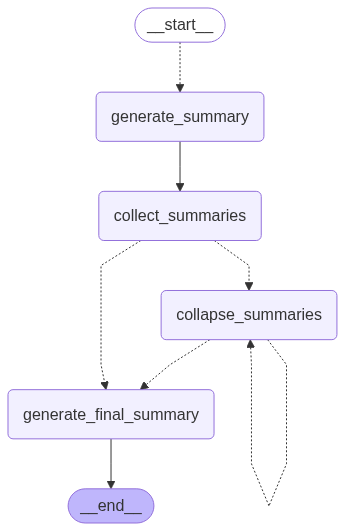

In [16]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

在运行该应用程序时，我们可以对图（graph）的执行过程进行流式输出，以观察其执行步骤序列。下面示例中，我们仅打印出每个步骤的名称。

请注意，由于图中存在循环结构，因此在执行时指定一个 `recursion_limit`（递归限制）会很有帮助。当超过该限制时，系统将抛出一个特定的错误，以防止无限循环。

In [17]:
async for step in app.astream(
    {"contents": [doc.page_content for doc in split_docs]},
    {"recursion_limit": 10},
):
    print(list(step.keys()))

['generate_summary']
['generate_summary']
['generate_summary']
['collect_summaries']
['generate_final_summary']


In [18]:
print(step)

{'generate_final_summary': {'final_summary': '天津市通过“智慧天津”建设展现了制造业和产业创新的显著成果，受到国内外关注。《今晚报》报道显示，天津市工业和信息化局在“工信动态”栏目中介绍了相关成就，强调产品实力获得认可。同时，中外记者参观了天津滨海新区现代产业展示交流中心，对企业创新成果如“火箭心”和安防系统表现出浓厚兴趣，并体验了数字化智能制造基地。此外，巴基斯坦媒体人希望借鉴中国经验推动技术交流与能力建设。相关信息还涉及天津市工业和信息化局官方网站的基本信息和服务功能，提示用户使用更高版本浏览器以优化访问体验。'}}
